In [12]:
# File: test_gguf_model_comparison.py

import os
import re
import json
import pandas as pd
from tqdm import tqdm
from llama_cpp import Llama
import matplotlib.pyplot as plt

# === Step 1: Setup ===
MODEL_DIR = "../models/mistral-gguf"
OUTPUT_PATH = "../outputs/nsclc_model_comparison_results.csv"
gguf_files = [f for f in os.listdir(MODEL_DIR) if f.endswith(".gguf")]

In [8]:
# === Step 2: Dummy Data ===
patients = [
    {"PatientID": "P001", "Text": "CT shows solid mass in right lung, biopsy confirms adenocarcinoma."},
    {"PatientID": "P002", "Text": "Mild inflammation noted. No solid tumors. Awaiting PET scan."},
    {"PatientID": "P003", "Text": "Progressive cough and weight loss. Chest X-ray suspicious for malignancy."}
]

In [10]:
# === Step 3: Prompt Template ===
def build_prompt(text):
    return f"""
You are a clinical language model. A patient medical report is provided below. Based on the full clinical context, classify the likelihood that the patient has non-small cell lung cancer (NSCLC) as one of:

- Definite
- Likely
- Unlikely
- Uncertain

Also provide a brief justification.

Patient report:
{text}

Respond in the following JSON format:
{{"NSCLC_Status": "", "Justification": ""}}
"""

In [14]:
# === Step 4: Run each model and collect results ===
results = []

for model_file in tqdm(gguf_files, desc="Testing models"):
    model_path = os.path.join(MODEL_DIR, model_file)
    try:
        llm = Llama(model_path=model_path, n_ctx=2048, n_threads=6)
    except Exception as e:
        print(f"Failed to load model {model_file}: {e}")
        continue

    for patient in patients:
        prompt = build_prompt(patient["Text"])
        response = llm(prompt, max_tokens=512, temperature=0.0, top_p=0.9)
        full_text = response["choices"][0]["text"]

        # Try to extract the JSON object from model output
        json_pattern = r"\{.*?\}"
        match = re.search(json_pattern, full_text, re.DOTALL)

        if match:
            try:
                parsed = json.loads(match.group(0))
                nsclc_status = parsed.get("NSCLC_Status", "")
                justification = parsed.get("Justification", "")
            except json.JSONDecodeError as e:
                nsclc_status = "ParseError"
                justification = f"JSON error after match: {e}\nRaw output: {match.group(0)}"
        else:
            nsclc_status = "ParseError"
            justification = f"No JSON found. Raw output: {full_text.strip()}"

        results.append({
            "Model": model_file,
            "PatientID": patient["PatientID"],
            "NSCLC_Status": nsclc_status,
            "Justification": justification
        })

Testing models:   0%|          | 0/12 [00:00<?, ?it/s]llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from ../models/mistral-gguf\mistral-7b-instruct-v0.1.Q2_K.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32 

Results saved to: ../outputs/nsclc_model_comparison_results.csv


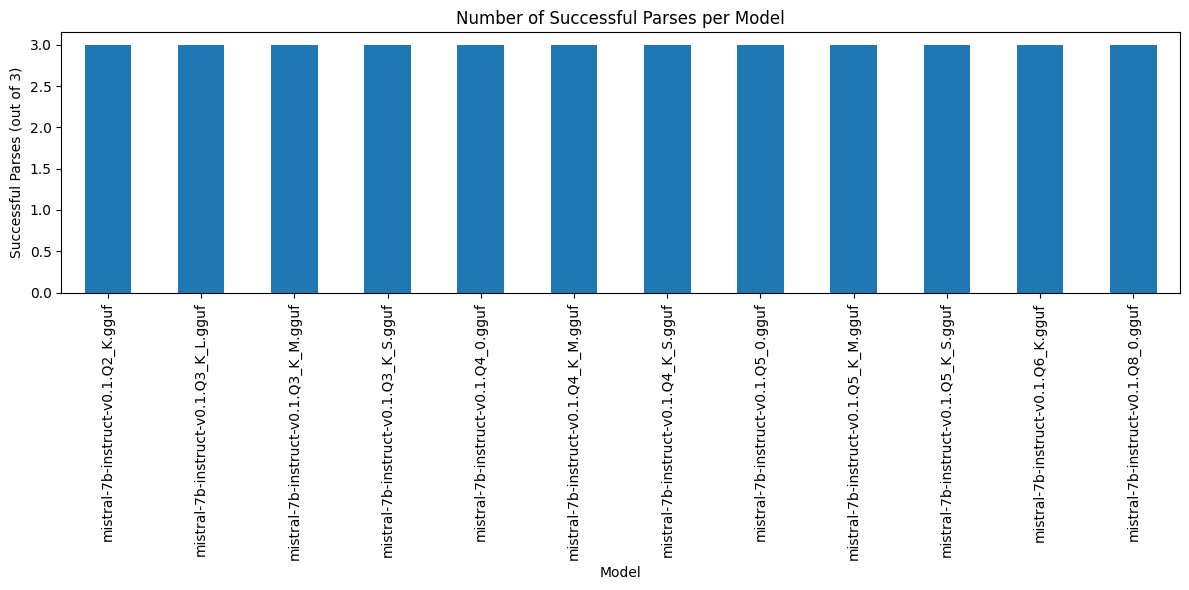

In [15]:
# === Step 5: Save results ===
df_results = pd.DataFrame(results)
os.makedirs("../outputs", exist_ok=True)
df_results.to_csv(OUTPUT_PATH, index=False)
print(f"Results saved to: {OUTPUT_PATH}")

# === Step 6: Plot success rate ===
summary = df_results.groupby("Model")["NSCLC_Status"].apply(lambda x: (x != "ParseError").sum())
summary.plot(kind="bar", title="Number of Successful Parses per Model", figsize=(12, 6))
plt.ylabel("Successful Parses (out of 3)")
plt.tight_layout()
plt.savefig("../outputs/model_parse_success.png")
plt.show()